# EWT

In [323]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.fft import fft, ifft

In [324]:
%run utils.ipynb

In [325]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


(array([5.0000e+00, 2.0000e+00, 3.7000e+01, 3.1340e+03, 1.5747e+04,
        3.9520e+03, 1.3330e+03, 4.8500e+02, 1.1300e+02, 3.2000e+01]),
 array([-500. , -362.9, -225.8,  -88.7,   48.4,  185.5,  322.6,  459.7,
         596.8,  733.9,  871. ]),
 <BarContainer object of 10 artists>)

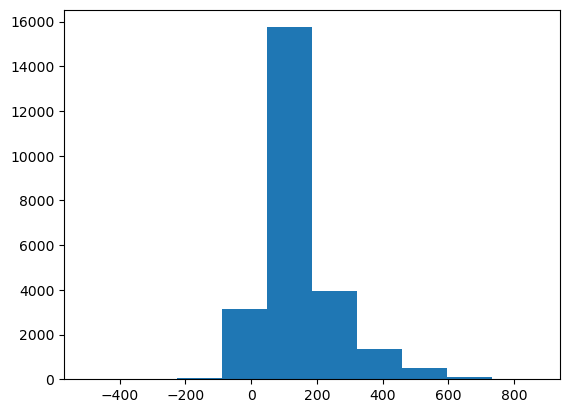

In [326]:
plt.hist(df_ori['price'])

In [327]:
df_ori['price'].describe()

count    24840.000000
mean       139.911127
std        115.040067
min       -500.000000
25%         75.075000
50%        106.145000
75%        180.000000
max        871.000000
Name: price, dtype: float64

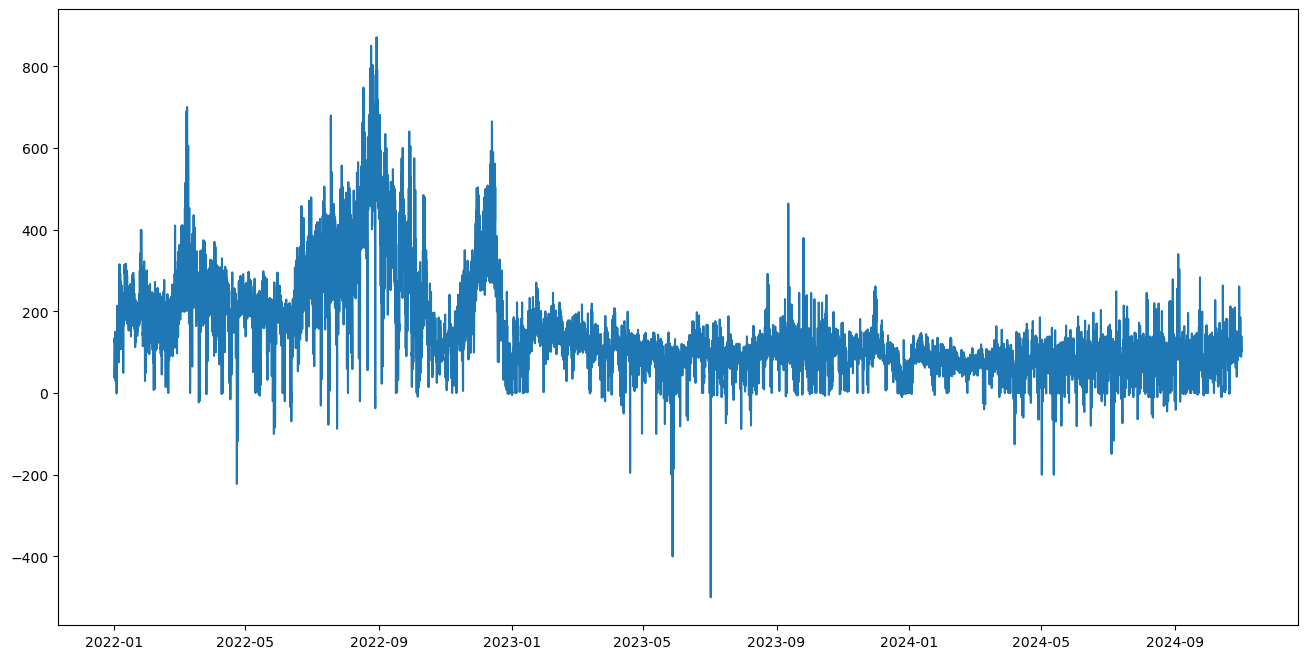

In [328]:
fig= plt.subplots(figsize=(16, 8))
plt.plot(df_ori['price'], label="Original Signal", linewidth=1.5)

In [329]:
# features = ['price', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore', 'actual_fossil_gas', 'actual_fossil_hard_coal']
features = ['price'] 

In [330]:
df = df_ori.loc['2022': '2024',  features]

In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   24840 non-null  float64
dtypes: float64(1)
memory usage: 388.1 KB


In [332]:
train_df = df.loc['2022': '2023']
test_df = df.loc['2024': '2024']

In [333]:
df.shape

(24840, 1)

## EWT decompose

In [334]:
sig_train, comps_train = ewt_decompose(train_df['price'], 4, lengthFilter= 6, sigmaFilter = 2)

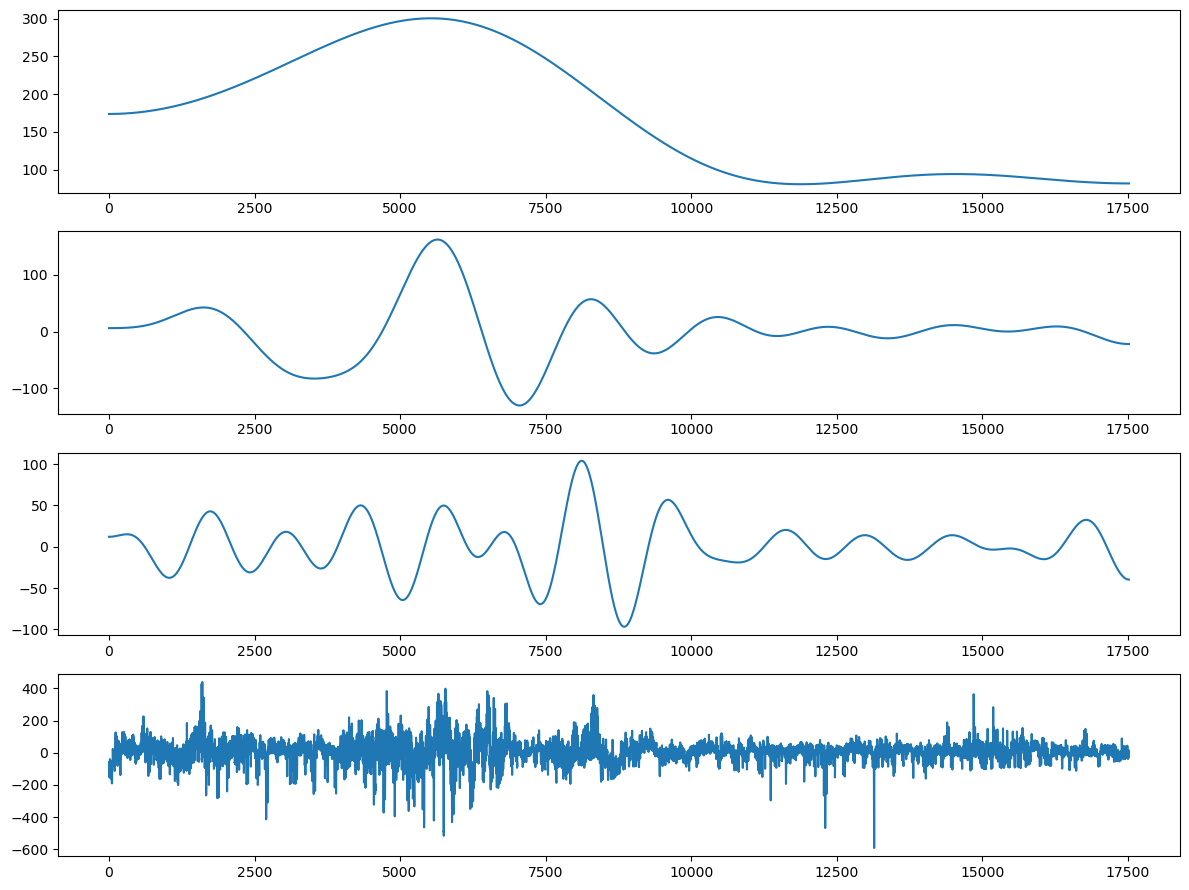

In [335]:

plot_ewt(comps_train)

In [336]:
sig_test, comps_test = ewt_decompose(test_df['price'], 4, lengthFilter= 10, sigmaFilter = 5)

## Function

Mean Absolute Error (MAE): 13.10
Root Mean Squared Error (RMSE): 17.43
Symmetric Mean Absolute Percentage Error (sMAPE): 17.66


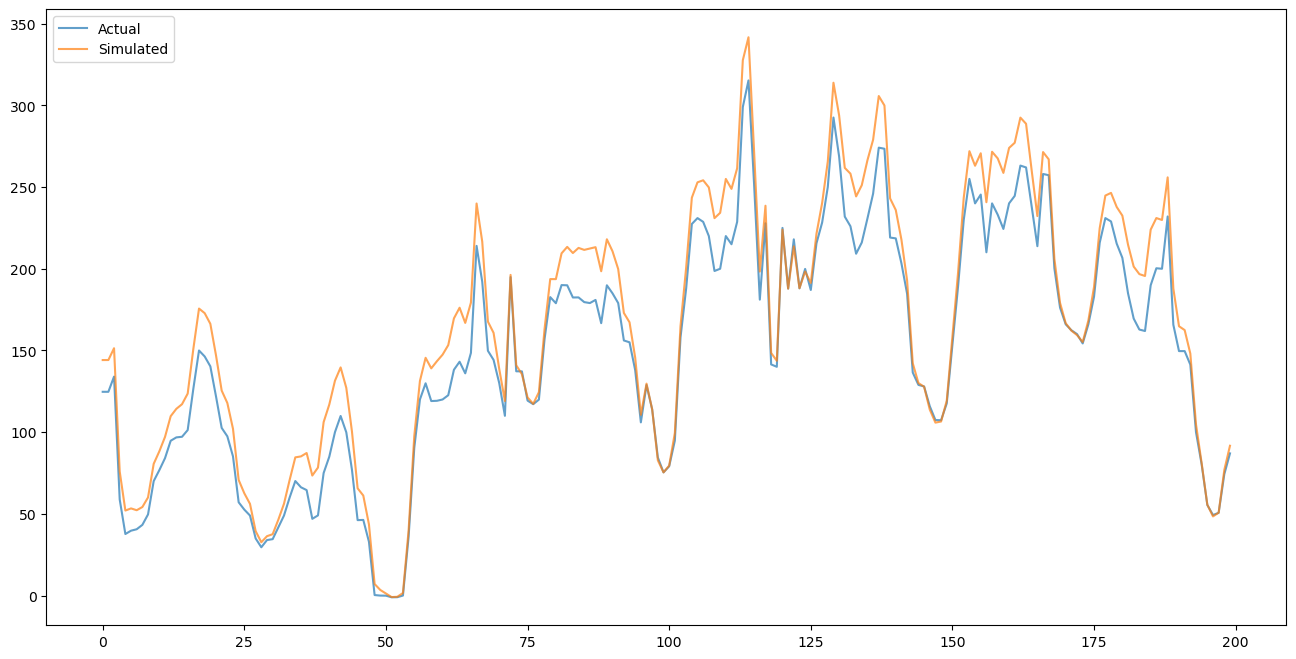

In [337]:
sig_train, comps_train = ewt_decompose(train_df['price'], 4, reg= 'gaussian',lengthFilter= 10, sigmaFilter = 5)
eva_s(train_df['price'].to_numpy(), sig_train)
fig, ax= plt.subplots(figsize=(16, 8))
plt.plot(train_df['price'].to_numpy()[:200], label = 'Actual',alpha = 0.7)
plt.plot(sig_train[:200], label = 'Simulated', alpha = 0.7)
ax.legend(loc=2)

Mean Absolute Error (MAE): 2.79
Root Mean Squared Error (RMSE): 3.67
Symmetric Mean Absolute Percentage Error (sMAPE): 16.20


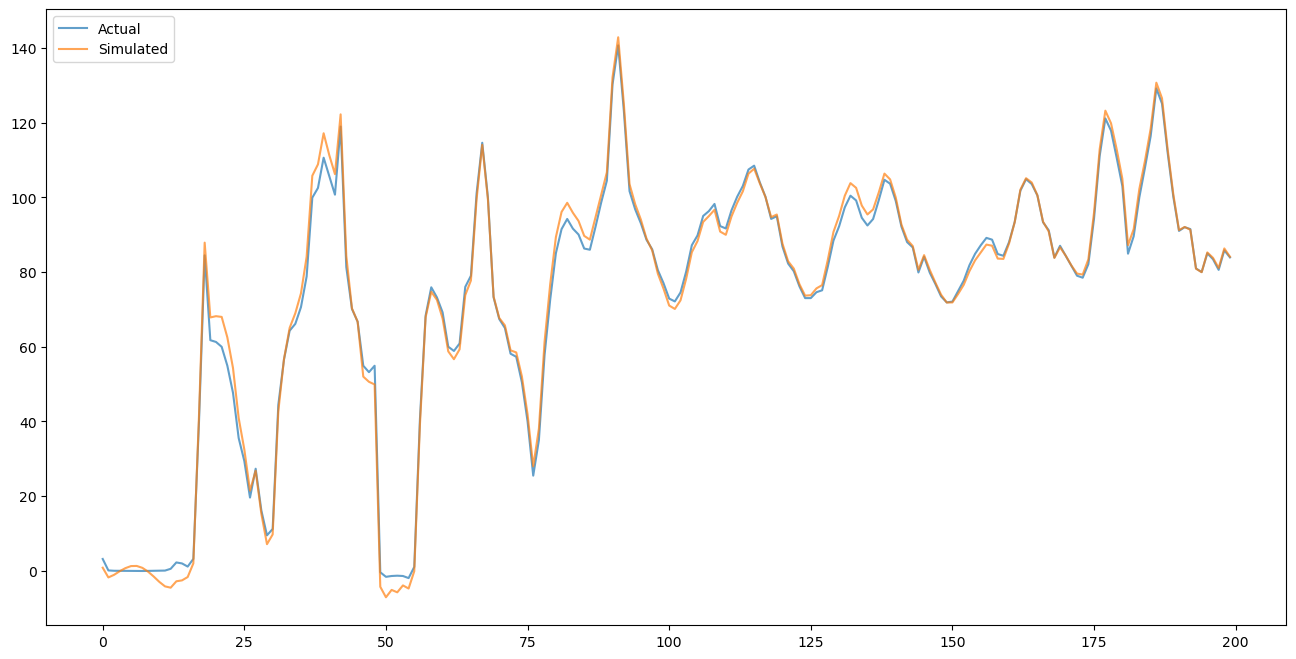

In [338]:
sig_test, comps_test = ewt_decompose(test_df['price'], 4, reg= 'gaussian', lengthFilter= 10, sigmaFilter = 5)
fig, ax= plt.subplots(figsize=(16, 8))
eva_s(test_df['price'].to_numpy(), sig_test)
plt.plot(test_df['price'].to_numpy()[:200], label = 'Actual',alpha = 0.7)
plt.plot(sig_test[:200], label = 'Simulated',alpha = 0.7)
ax.legend(loc=2)

In [339]:
comps_train.shape[1]

4

In [340]:
def lstm_model_ewt(train_data, test_data):
    # Step 3: Normalize each component separately
    scaler = MinMaxScaler()
    # train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    # test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    
    # train_scaled = train_data.reshape(-1, 1)
    
    def create_seq(data, seq_length=24):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :])  # Previous `window_size` steps across all components
            y.append(data[i + seq_length, 0])
    
        return np.array(X), np.array(y)
    
    X_train, y_train = create_seq(train_scaled, 24)
    X_test, y_test = create_seq(test_scaled, 24)# Step 5: Define the LSTM model
    
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)

    print('Predict on X_test.')
    y_pred = model.predict(X_test)
    
    print('Predict on X_train.')
    train_pred = model.predict(X_train)
    # Predict
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    trian_pred_rescaled = scaler.inverse_transform(train_pred.reshape(-1, 1))

    
    mae, rsme, mape = eva_s(y_test_rescaled, y_pred_rescaled)

    y_test_preds = [y_test_rescaled,y_pred_rescaled]
    performance = [mae, rsme, mape]

    return model, y_test_preds, performance, trian_pred_rescaled
    
    # return model

In [341]:
models = []
test_preds =[]
metrics = []
train_preds = []
for i in range(comps_train.shape[1]):
# for i in range(1):
    print('components:',i)
    train_data = comps_train[:,i]
    test_data = comps_test[:,i]
    model, y_test_preds, performance, trian_pred_rescaled = lstm_model_ewt(train_data, test_data)
    models.append(model)
    test_preds.append(y_test_preds)
    metrics.append(performance)
    train_preds.append(trian_pred_rescaled)
    

components: 0


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0053
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.3320e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.2022e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 8.1820e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.5052e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.2618e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.2981e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 4.3134e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.0431e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.0224e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.8459e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.1052e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.3393e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0104
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.8456e-04
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.2782e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 8.6626e-05
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.8233e-05
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.7449e-05
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.9306e-05
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.4366e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.5079e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 3.3860e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.7906e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.1426e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.9920e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0192
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0011
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 3.1968e-04
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.2376e-04
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.5530e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.2905e-04
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1395e-04
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 9.8764e-05
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.1965e-05
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7.8844e-05
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 6.2500e-05
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.2360e-05
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.6042e-05
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.7241

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0192
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0041
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0018
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0014
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0013
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0012
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0011
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0011
Epoch 9/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0011
Epoch 10/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0011
Epoch 11/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0010
Epoch 12/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0010
Epoch 13/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0010
Epoch 14/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.3751e-04
Epoch 15/20
547/547 ━━━━━━━━━━━━━━━━━━━

In [342]:
test_preds_n = np.asarray(test_preds)

In [343]:
y_t = test_preds_n[:,0,:,:]
y_p = test_preds_n[:,1,:,:]

In [344]:
y_t_sum = np.sum(y_t, axis=0).reshape(-1,1)
y_p_sum = np.sum(y_p, axis=0).reshape(-1,1)

In [345]:
y_t_sum[:3]

array([[40.91672201],
       [32.47538498],
       [21.44241291]])

In [346]:
test_comp_sum = np.sum(comps_test, axis=1).reshape(-1,1)

In [347]:
test_comp_sum.shape

(7321, 1)

In [348]:
test_comp_sum[24: 30]

array([[40.91672201],
       [32.47538498],
       [21.44241291],
       [26.78783376],
       [15.30939255],
       [ 7.12800616]])

In [349]:
y_p_sum.shape

(7297, 1)

In [350]:
test_df['price'][168:].shape

(7153,)

In [351]:
eva_s(y_t_sum, y_p_sum)

Mean Absolute Error (MAE): 10.11
Root Mean Squared Error (RMSE): 13.37
Symmetric Mean Absolute Percentage Error (sMAPE): 26.69


(10.108794594856654, 13.369001706391803, 26.68523597105419)

In [352]:
eva_s(test_df['price'][24:].to_numpy().reshape(-1,1), y_p_sum)

Mean Absolute Error (MAE): 10.71
Root Mean Squared Error (RMSE): 14.14
Symmetric Mean Absolute Percentage Error (sMAPE): 30.76


(10.705732416818398, 14.137080982671428, 30.75910918981216)

In [353]:
test_df['price'][24: 30]

2024-01-02 00:00:00    35.55
2024-01-02 01:00:00    29.39
2024-01-02 02:00:00    19.60
2024-01-02 03:00:00    27.33
2024-01-02 04:00:00    16.20
2024-01-02 05:00:00     9.50
Name: price, dtype: float64

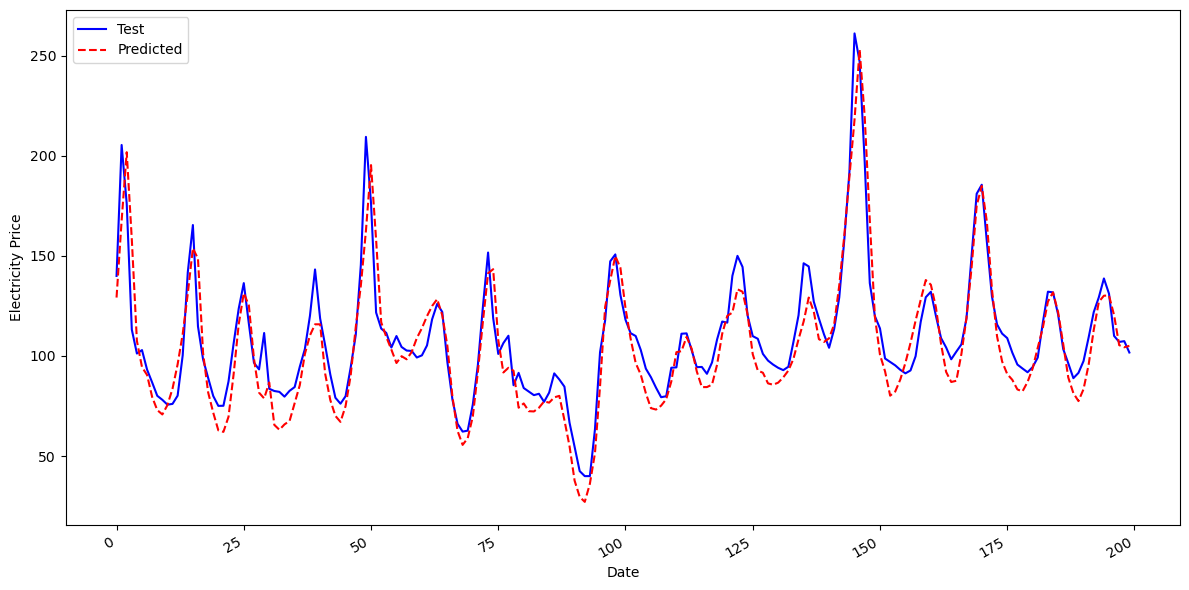

In [355]:
compare_preds(test_df['price'][24:].to_numpy().reshape(-1,1)[-200:], y_p_sum[-200:])

In [33]:
a = np.array([8.47, 12.07, 25.85])
b = np.array([10.25, 14.81, 27.66])

In [34]:
(b - a) / b * 100

array([17.36585366, 18.50101283,  6.54374548])

# Stacking

In [356]:
train_preds[0][5]

array([212.78798], dtype=float32)

In [357]:
train_preds_nd = np.array(train_preds)

In [358]:
train_preds_nd.shape

(4, 17495, 1)

In [359]:
train_comp_sum = np.sum(train_preds_nd, axis=0).reshape(-1,1)

In [360]:
len(train_comp_sum)

17495

In [361]:
train_error = train_df['price'][24:].to_numpy().reshape(-1,1) -  train_comp_sum

In [362]:
train_error.shape

(17495, 1)

In [363]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.6 MB


In [364]:
error_features = ['total_load', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore']
df_error = df_ori.loc[ '2022': '2023', error_features][24:]
# df_error = df_ori.loc[ '2024':, :][24:]


In [365]:
df_error['error'] = train_error

In [366]:
df_error['error'].describe()

count    17495.000000
mean         5.780475
std         24.735670
min       -232.653259
25%         -7.049913
50%          5.938658
75%         18.938405
max        222.226685
Name: error, dtype: float64

In [367]:
df_error.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17495 entries, 2022-01-02 01:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_load            17495 non-null  int64  
 1   actual_solar          17495 non-null  int64  
 2   actual_wind_onshore   17495 non-null  int64  
 3   actual_wind_offshore  17495 non-null  int64  
 4   error                 17495 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 820.1 KB


In [368]:
mean = df_error['error'].mean()
std_dev = df_error['error'].std()
print(f"Mean: {mean}, Standard Deviation: {std_dev}")

Mean: 5.780474937095543, Standard Deviation: 24.7356697804001


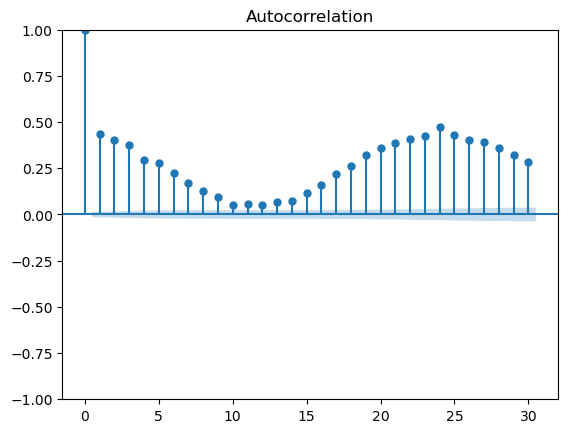

In [369]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_error['error'], lags=30)
plt.show()

In [49]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming df is the DataFrame containing your data
# df = pd.read_csv('your_data.csv')

# Separate features and target variable
X = df_error[error_features]
y = df_error['error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the DNN model
model_error = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_error.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model_error.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

model_error_pred = model_error.predict(X_test)
# Evaluate the model
# test_loss, test_mae = model.evaluate(X_test, y_test)
# print(f'Test MAE: {test_mae}')


Epoch 1/20


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 635.9685 - mae: 18.2133 - val_loss: 608.4473 - val_mae: 17.7429
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 627.3611 - mae: 17.9844 - val_loss: 604.4211 - val_mae: 17.6971
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 615.3235 - mae: 17.9536 - val_loss: 603.8315 - val_mae: 17.6841
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 610.3203 - mae: 17.6376 - val_loss: 603.4133 - val_mae: 17.6692
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 617.5773 - mae: 17.8342 - val_loss: 601.8525 - val_mae: 17.6561
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 604.1773 - mae: 17.7110 - val_loss: 602.1782 - val_mae: 17.6697
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 606.4611 - mae: 17.8648 - val_loss: 602.0430 - val_mae: 17.6272
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 616.8320 - mae: 17.8327 - val_loss: 603.3900 - val_mae: 17.6954
Epoch

In [50]:
model_error_pred = model_error.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step


In [51]:
model_error_pred.shape

(3499, 1)

In [52]:
eva_s(y_test, model_error_pred.reshape(-1))

Mean Absolute Error (MAE): 18.26
Root Mean Squared Error (RMSE): 25.38
Symmetric Mean Absolute Percentage Error (sMAPE): 139.90


(18.26212964765095, 25.380486990396406, 139.89691518485785)

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Assuming df is the DataFrame containing your data
# df = pd.read_csv('your_data.csv')

# Separate features and target variable
X = df_error[error_features]
y = df_error['error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance (optional for Random Forests, but it can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

rf_model_error_pred = rf_model.predict(X_test)

# Lagged LSTM

In [312]:
df_ori = load_data('df_actual_22_24_cleaned')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB
None


In [313]:
df_b = df_ori[['price']]

In [314]:
lags = [1, 2, 25, 168]
# features = ['price','wind_onshore', 'wind_offshore', 'solar', 'total_load']
lag_features = ['price']
# features = ['wind_onshore', 'wind_offshore', 'solar', 'total_load']
# features = ['price']

# Create lagged features for each feature at specified lags
for feature in lag_features:
    for lag in lags:
        df_b.loc[:, f"{feature}_lag_{lag}"] = df_b[feature].shift(lag)

/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_3115/3954546081.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.loc[:, f"{feature}_lag_{lag}"] = df_b[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_3115/3954546081.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.loc[:, f"{feature}_lag_{lag}"] = df_b[feature].shift(lag)
/var/folders/8k/8n8mf6jn28537sc4vvz36rhh0000gn/T/ipykernel_3115/3954546081.py:10: SettingWithCopyWarning: 
A value is trying to be

In [315]:
df_b.head()

price  price_lag_1  price_lag_2  price_lag_25  \
2022-01-01 01:00:00  124.70          NaN          NaN           NaN   
2022-01-01 02:00:00  124.70        124.7          NaN           NaN   
2022-01-01 03:00:00  134.00        124.7        124.7           NaN   
2022-01-01 04:00:00   58.80        134.0        124.7           NaN   
2022-01-01 05:00:00   37.67         58.8        134.0           NaN   

                     price_lag_168  
2022-01-01 01:00:00            NaN  
2022-01-01 02:00:00            NaN  
2022-01-01 03:00:00            NaN  
2022-01-01 04:00:00            NaN  
2022-01-01 05:00:00            NaN

In [316]:
df_b = df_b.dropna()

In [317]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24672 entries, 2022-01-08 01:00:00 to 2024-11-01 00:00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          24672 non-null  float64
 1   price_lag_1    24672 non-null  float64
 2   price_lag_2    24672 non-null  float64
 3   price_lag_25   24672 non-null  float64
 4   price_lag_168  24672 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


In [318]:
train_df = df_b['2022': '2023']
test_df = df_b['2024': '2024']

In [319]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17351 entries, 2022-01-08 01:00:00 to 2023-12-31 23:00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17351 non-null  float64
 1   price_lag_1    17351 non-null  float64
 2   price_lag_2    17351 non-null  float64
 3   price_lag_25   17351 non-null  float64
 4   price_lag_168  17351 non-null  float64
dtypes: float64(5)
memory usage: 813.3 KB


In [320]:
features = train_df.columns.tolist()

In [321]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.optimizers import Adam
# # Assuming 'df' is your dataframe with 'price' and a DateTime index
# # Filter and split data into training and test sets
# train_data = df['2022':'2023'][['price']].values
# test_data = df['2024'][['price']].values

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled_df = scaler.fit_transform(train_df)
test_scaled_df = scaler.transform(test_df)

# Convert scaled data to DataFrame for consistency in `create_sequences` function
train_scaled_df = pd.DataFrame(train_scaled_df, columns=features)
test_scaled_df = pd.DataFrame(test_scaled_df, columns=features)
# Create sequences for the training set
sequence_length = 24
# X_train, y_train = [], []

# for i in range(sequence_length, len(scaled_train)):
#     X_train.append(scaled_train[i - sequence_length:i, 0])
#     y_train.append(scaled_train[i, 0])

X_train, y_train = create_sequences_2(train_scaled_df, seq_length = 24, features = features)
X_test, y_test = create_sequences_2(test_scaled_df, seq_length = 24, features = features)

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
# model_basic_LSTM = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=50))
# model.add(Dense(units=1))
model_lagged_LSTM = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=32, return_sequences=False),
        Dense(units=1)
    ])

# Compile the model
model_lagged_LSTM.compile(optimizer='adam', loss='mean_squared_error')

model_lagged_LSTM.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [322]:
# Train the model
model_lagged_LSTM.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0090
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0021
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.6107e-04
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.2842e-04
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.3970e-04
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.7758e-04
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 5.2662e-04
Epoch 9/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.5056e-04
Epoch 10/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.5753e-04
Epoch 11/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.2472e-04
Epoch 12/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.2766e-04
Epoch 13/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 4.2372e-04
Epoch 14/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.0321e-04

In [197]:
# # Prepare the test set sequences
# X_test, y_test = [], []

# # Use scaled_test for creating sequences in the test set
# for i in range(sequence_length, len(scaled_test)):
#     X_test.append(scaled_test[i - sequence_length:i, 0])
#     y_test.append(scaled_test[i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict on test set
predicted_price = model_lagged_LSTM.predict(X_test)
# predicted_price = scaler.inverse_transform(predicted_price)  # Rescale to original values

# # Rescale the actual test prices for comparison
# actual_price = scaler.inverse_transform(scaled_test[sequence_length:])


229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [198]:
y_test_rescaled, y_pred_rescaled = eva(y_test, predicted_price, X_test)

Mean Absolute Error (MAE): 9.19
Root Mean Squared Error (RMSE): 13.95
Symmetric Mean Absolute Percentage Error (sMAPE): 25.26


In [199]:
pred_y_train = model_lagged_LSTM.predict(X_train)
# y_train_rescaled - x_train_rescaled

542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [200]:
y_train_rescaled, x_train_rescaled = eva(y_train, pred_y_train, X_train)

Mean Absolute Error (MAE): 16.65
Root Mean Squared Error (RMSE): 25.39
Symmetric Mean Absolute Percentage Error (sMAPE): 17.24


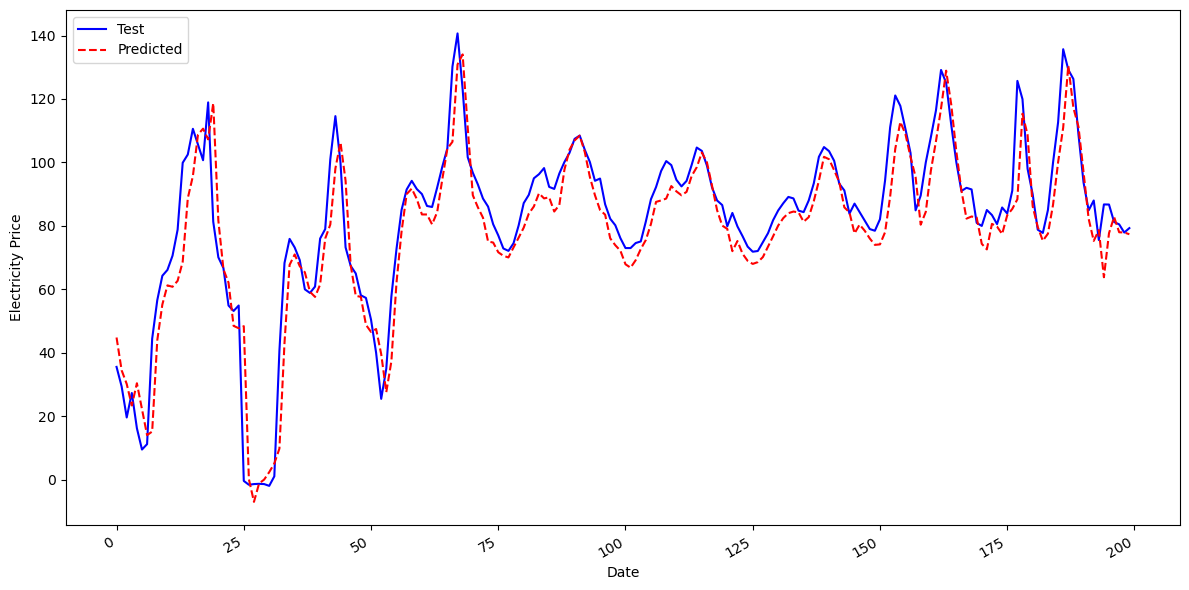

In [201]:
compare_preds(y_test_rescaled[:200], y_pred_rescaled[:200])

In [202]:
error_series_LSTM = y_test_rescaled - y_pred_rescaled

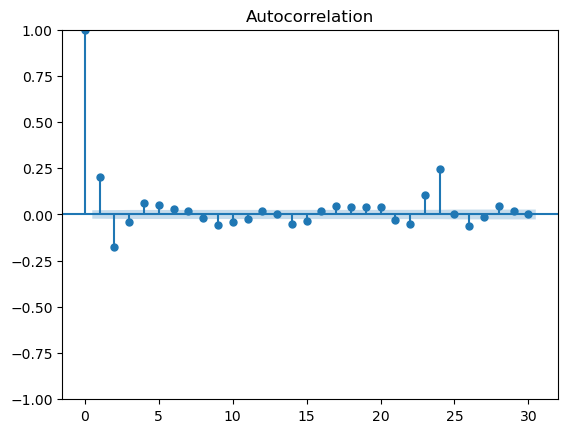

In [203]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(error_series_LSTM, lags=30)
plt.show()

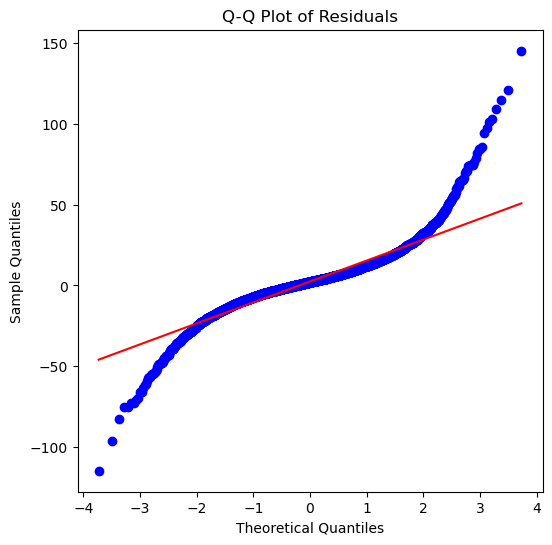

In [204]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming 'error_series' is your residual series
# Example: error_series = y_true - y_pred

# Generate the Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(error_series_LSTM, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# Error Model

In [205]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24840 entries, 2022-01-01 01:00:00 to 2024-11-01 00:00:00
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    24840 non-null  float64
 1   solar                    24840 non-null  int64  
 2   wind_onshore             24840 non-null  int64  
 3   wind_offshore            24840 non-null  int64  
 4   total_load               24840 non-null  int64  
 5   actual_solar             24840 non-null  int64  
 6   actual_wind_onshore      24840 non-null  int64  
 7   actual_wind_offshore     24840 non-null  int64  
 8   actual_fossil_gas        24840 non-null  int64  
 9   actual_fossil_hard_coal  24840 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB


In [259]:
# error_features = ['solar', ,'total_load', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore']
error_features = ['solar', 'wind_onshore','wind_offshore','actual_fossil_gas', 'actual_fossil_hard_coal', 'total_load', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore']
# error_features = ['solar', 'wind_onshore','wind_offshore', 'total_load', 'actual_solar', 'actual_wind_onshore', 'actual_wind_offshore']
df_error = df_ori.loc[ '2022': '2023', error_features][168 + 24:]

In [260]:
df_error.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17327 entries, 2022-01-09 01:00:00 to 2023-12-31 23:00:00
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   solar                    17327 non-null  int64
 1   wind_onshore             17327 non-null  int64
 2   wind_offshore            17327 non-null  int64
 3   actual_fossil_gas        17327 non-null  int64
 4   actual_fossil_hard_coal  17327 non-null  int64
 5   total_load               17327 non-null  int64
 6   actual_solar             17327 non-null  int64
 7   actual_wind_onshore      17327 non-null  int64
 8   actual_wind_offshore     17327 non-null  int64
dtypes: int64(9)
memory usage: 1.3 MB


In [261]:
error_series_LSTM.shape

(7297,)

In [262]:
error_series_lagged = y_train_rescaled - x_train_rescaled.reshape(-1)

In [263]:
y_train_rescaled[:5]

array([141.32, 100.  ,  80.24,  55.46,  49.29])

In [264]:
x_train_rescaled[:5]

array([127.96413568, 115.55804065,  81.38530251,  63.86447987,
        46.20318404])

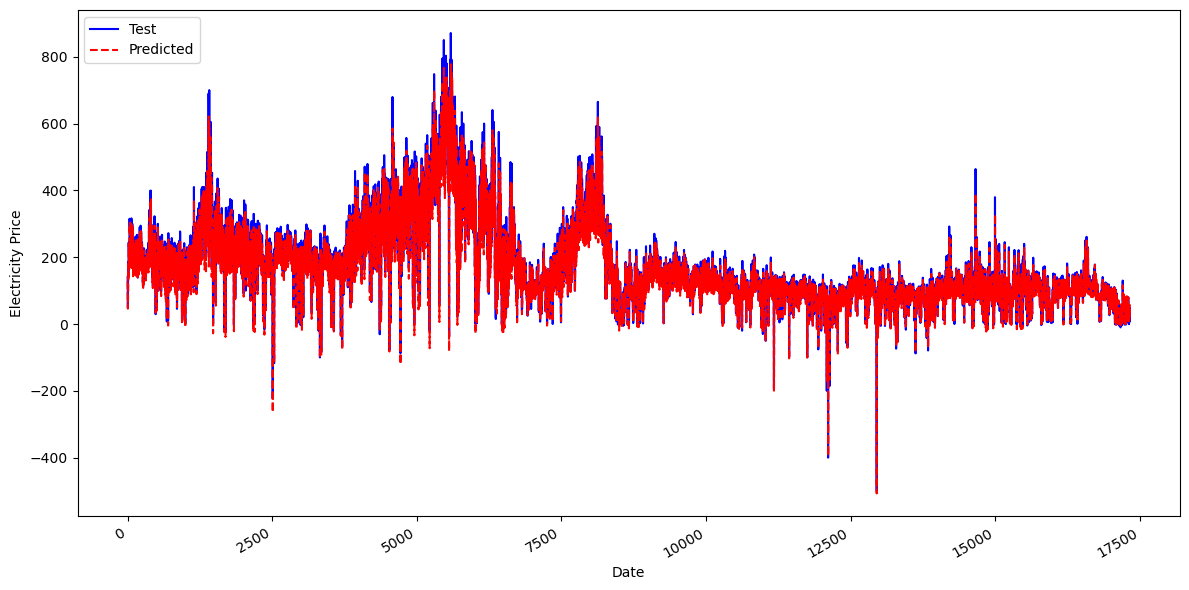

In [265]:
compare_preds(y_train_rescaled, x_train_rescaled)

In [266]:
df_error['error_series'] = error_series_lagged

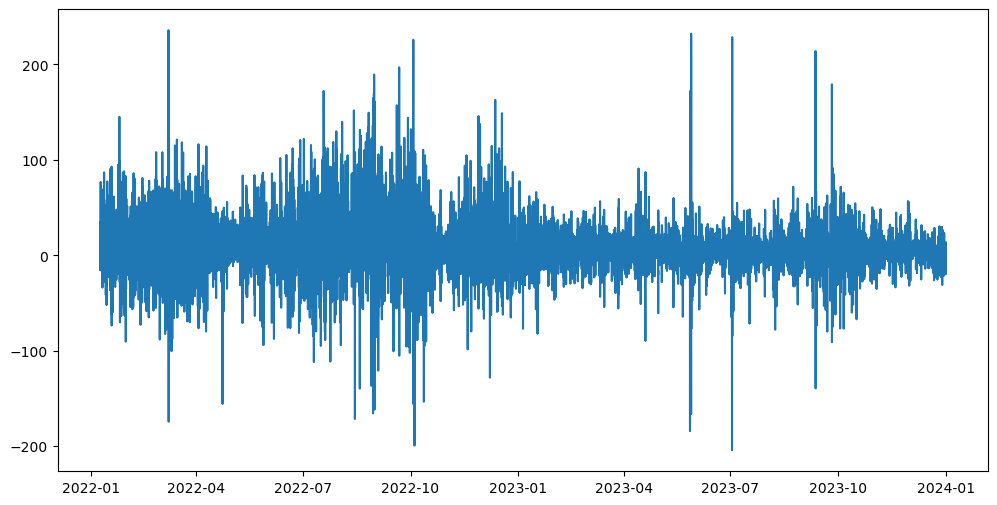

In [291]:
fig, ax = plt.subplots(figsize= (12,6))
plt.plot(df_error['error_series'])

In [292]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming df is the DataFrame containing your data
# df = pd.read_csv('your_data.csv')

# Separate features and target variable
X = df_error[error_features]
y = df_error['error_series']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the DNN model
model_error = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model_error.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model_error.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

model_error_pred = model_error.predict(X_test)
# Evaluate the model
test_loss, test_mae = model_error.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')


Epoch 1/20


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 601.7594 - mae: 15.6441 - val_loss: 555.6216 - val_mae: 14.7822
Epoch 2/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 545.1802 - mae: 14.8224 - val_loss: 554.9345 - val_mae: 14.9822
Epoch 3/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 532.4129 - mae: 14.7455 - val_loss: 553.4426 - val_mae: 14.7340
Epoch 4/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 533.3169 - mae: 14.7362 - val_loss: 552.2053 - val_mae: 14.7653
Epoch 5/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 508.6317 - mae: 14.5218 - val_loss: 553.5002 - val_mae: 14.9328
Epoch 6/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 497.6463 - mae: 14.3948 - val_loss: 552.1240 - val_mae: 14.8248
Epoch 7/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 526.4236 - mae: 14.6518 - val_loss: 552.4606 - val_mae: 14.6712
Epoch 8/20
347/347 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 508.4853 - mae: 14.4473 - val_loss: 552.9532 - val_mae: 14.7273
Epoch 9/20


In [293]:
model_error_pred[:5]

array([[13.151484 ],
       [14.408276 ],
       [-5.5156302],
       [-3.6904242],
       [23.037277 ]], dtype=float32)

In [294]:
X.head()

solar  wind_onshore  wind_offshore  actual_fossil_gas  \
2022-01-09 01:00:00      0         15515           5633               7337   
2022-01-09 02:00:00      0         16176           5679               5352   
2022-01-09 03:00:00      0         16479           5669               4512   
2022-01-09 04:00:00      0         16737           5661               4766   
2022-01-09 05:00:00      0         16648           5651               4465   

                     actual_fossil_hard_coal  total_load  actual_solar  \
2022-01-09 01:00:00                     8588       44754             0   
2022-01-09 02:00:00                     8095       42759             0   
2022-01-09 03:00:00                     7136       41717             0   
2022-01-09 04:00:00                     6933       41300             0   
2022-01-09 05:00:00                     7008       41236             0   

                     actual_wind_onshore  actual_wind_offshore  
2022-01-09 01:00:00                 4448                  7600  
2022-01-09 02:00:00                 5284                  7987  
2022-01-09 03:00:00                 7339                  7553  
2022-01-09 04:00:00                 7780                  7768  
2022-01-09 05:00:00                 7697                  8697

In [295]:
X_test.shape

(3466, 9)

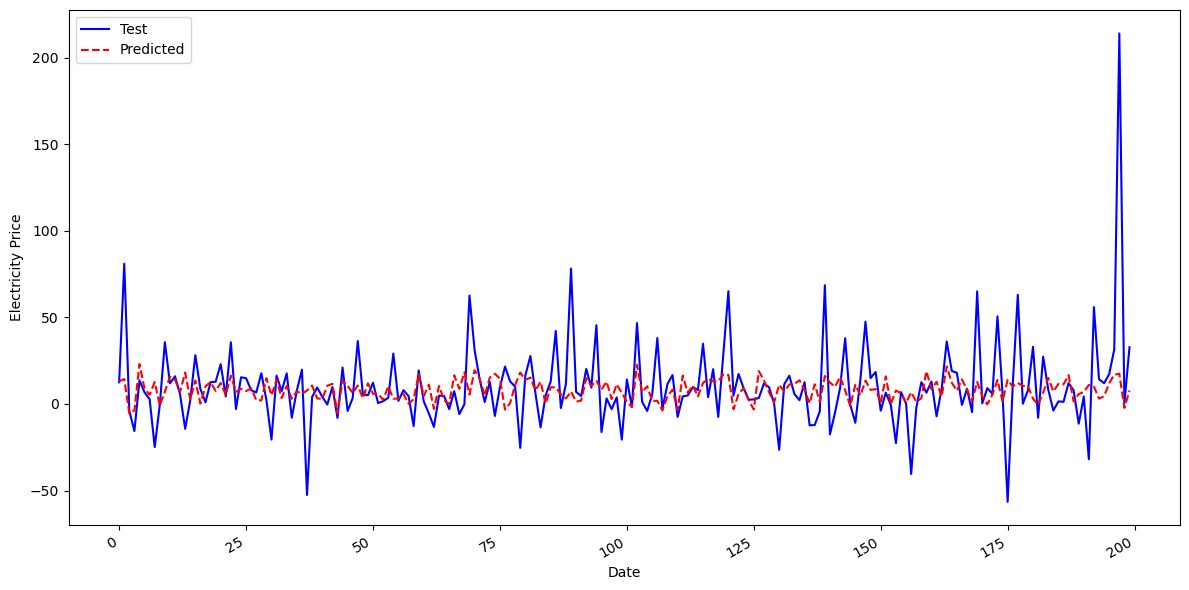

In [296]:
compare_preds(y_test.to_numpy()[:200], model_error_pred[:200])

## pred error adj on test

In [297]:
X_error_series_test = y_test_rescaled - y_pred_rescaled

In [298]:
y_test_rescaled.shape

(7297,)

In [299]:
df_error_real = df_ori.loc['2024', error_features][24:]

In [300]:
X_error_series_test_scaled = scaler.transform(df_error_real)

In [301]:
error_adj = model_error.predict(X_error_series_test_scaled)

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


In [302]:
X_error_series_test[:5]

array([ -9.26549037,  -5.09825958, -10.56145661,   3.95297338,
       -14.19794841])

In [303]:
error_adj[:5]

array([[-2.7982078],
       [-2.8616626],
       [-3.0559566],
       [-3.1581817],
       [-3.301684 ]], dtype=float32)

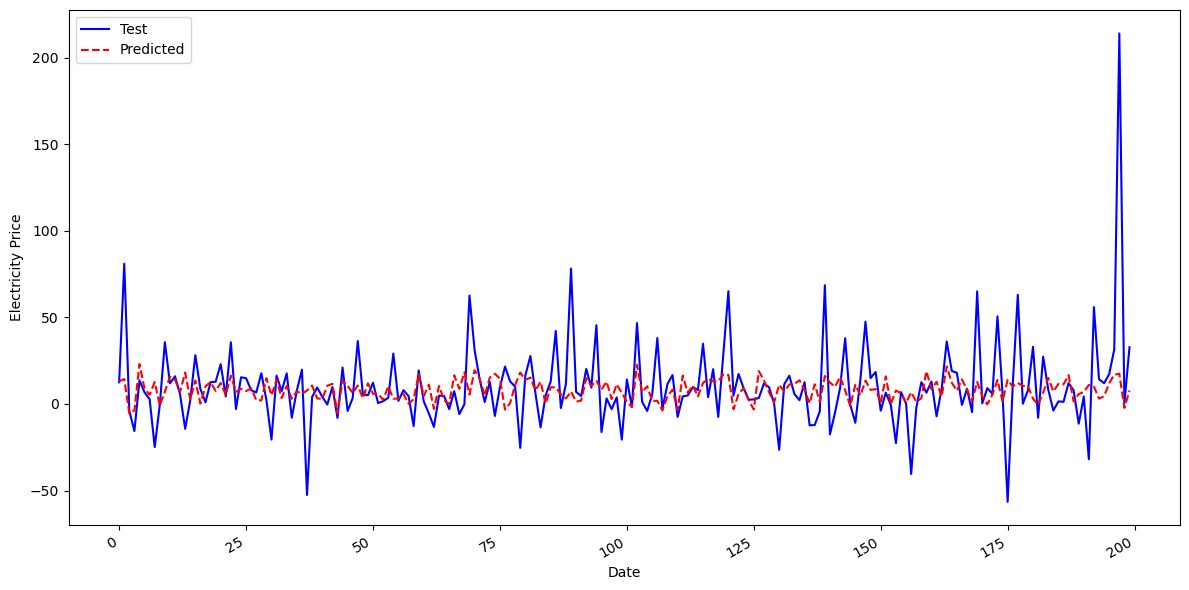

In [304]:
compare_preds(y_test.to_numpy()[:200], model_error_pred[:200])

In [305]:
# Get the sign of each element (+1 for positive, -1 for negative, and 0 for zero)
signs1 = np.sign(X_error_series_test)
signs2 = np.sign(error_adj.reshape(-1))

# Compare signs column-wise (axis=0)
matching_signs = signs1 == signs2

# Count columns with matching signs
num_matching_columns = np.sum(matching_signs)
print(num_matching_columns)

4593


In [306]:
y_pred_rescaled.shape

(7297,)

In [307]:
error_adj.reshape(-1).shape

(7297,)

In [308]:
y_adj = y_pred_rescaled + error_adj.reshape(-1)

In [309]:
eva_s(y_test_rescaled, y_adj)

Mean Absolute Error (MAE): 9.38
Root Mean Squared Error (RMSE): 13.83
Symmetric Mean Absolute Percentage Error (sMAPE): 25.38


(9.377961113848174, 13.825562271406351, 25.38240105735352)

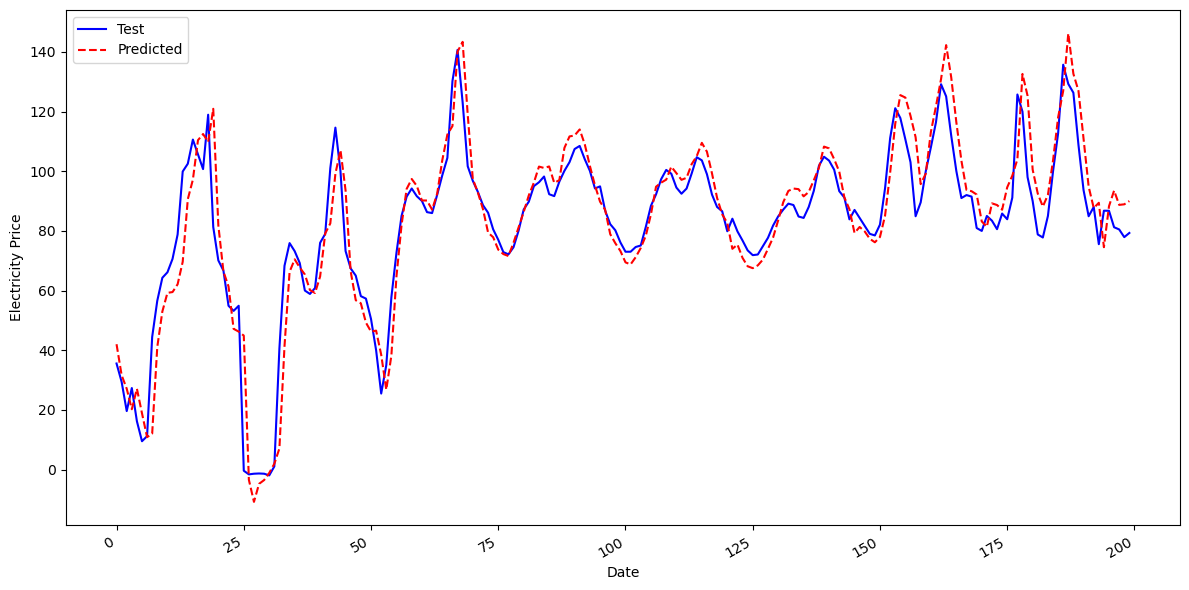

In [310]:
compare_preds(y_test_rescaled[:200], y_adj[:200])

<function matplotlib.pyplot.show(close=None, block=None)>

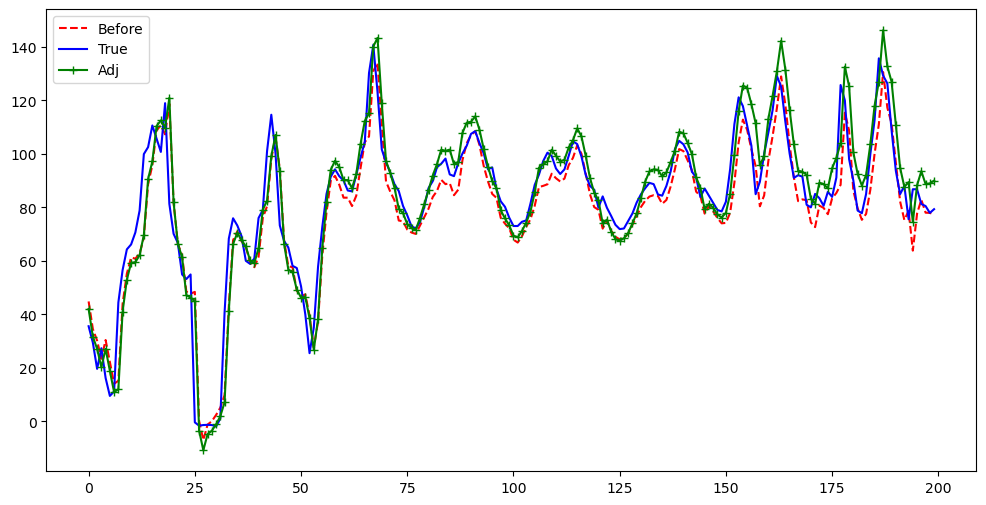

In [311]:
m=0
n=200
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(y_pred_rescaled[m:n],'r--', label = 'Before')
plt.plot(y_test_rescaled[m:n], 'b-', label = 'True')
plt.plot(y_adj[m:n], 'g-+',label = 'Adj')
ax.legend(loc=2)
plt.show

In [251]:
eva_s(y_test_rescaled, y_adj)

Mean Absolute Error (MAE): 10.14
Root Mean Squared Error (RMSE): 14.51
Symmetric Mean Absolute Percentage Error (sMAPE): 26.90


(10.140085136846123, 14.509536795231833, 26.895011041357662)

In [252]:
# Mean Absolute Error (MAE): 10.98
# Root Mean Squared Error (RMSE): 15.27
# Symmetric Mean Absolute Percentage Error (sMAPE): 28.92

In [253]:
# Mean Absolute Error (MAE): 9.82
# Root Mean Squared Error (RMSE): 14.35
# Symmetric Mean Absolute Percentage Error (sMAPE): 27.12

In [254]:
from dieboldmariano import dm_test

In [255]:
T = y_test_rescaled
F = y_pred_rescaled
G = y_adj

dm_test(T, F, G, one_sided=True)

(-5.017342283964903, 2.681474846632718e-07)

In [256]:
import numpy as np
from scipy.stats import t

def diebold_mariano_test(y_true, y_pred1, y_pred2, horizon=1, crit='MSE'):
    """
    Perform the Diebold-Mariano test for equal predictive accuracy.

    Parameters:
        y_true (array): The true values.
        y_pred1 (array): Predictions from the first model.
        y_pred2 (array): Predictions from the second model.
        horizon (int): The forecast horizon, default is 1.
        crit (str): The criterion to use ('MSE' or 'MAE').

    Returns:
        dm_stat (float): The Diebold-Mariano test statistic.
        p_value (float): The p-value of the test.
    """
    # Calculate errors
    error1 = y_true - y_pred1
    error2 = y_true - y_pred2
    
    # Calculate loss differential based on chosen criterion
    if crit == 'MSE':
        d = (error1**2) - (error2**2)
    elif crit == 'MAE':
        d = np.abs(error1) - np.abs(error2)
    else:
        raise ValueError("Criterion must be 'MSE' or 'MAE'")
    
    # Calculate mean and variance of the loss differential
    mean_d = np.mean(d)
    variance_d = np.var(d, ddof=1)
    
    # Adjust variance for forecast horizon
    adj_variance_d = variance_d / len(d)
    
    # Diebold-Mariano test statistic
    dm_stat = mean_d / np.sqrt(adj_variance_d)
    
    # Calculate p-value
    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=len(d) - 1))
    
    return dm_stat, p_value

In [257]:
dm_stat, p_value = diebold_mariano_test(y_test_rescaled, y_pred_rescaled, y_adj, horizon=1, crit='MSE')
print(f"Diebold-Mariano statistic: {dm_stat}")
print(f"P-value: {p_value}")


Diebold-Mariano statistic: -5.017342283964896
P-value: 5.362949699883046e-07


In [258]:
rt1 = dm_test_cus(y_test_rescaled + 0.0001, y_pred_rescaled+ 0.0001, y_adj+ 0.0001,h = 1, crit="MAD")
print(rt1)
rt2 = dm_test_cus(y_test_rescaled+ 0.0001, y_pred_rescaled+ 0.0001, y_adj+ 0.0001,h = 1, crit="MSE")
print(rt2)
rt3 = dm_test_cus(y_test_rescaled+ 0.0001, y_pred_rescaled+ 0.0001, y_adj+ 0.0001,h = 1, crit="MAPE")
print(rt3)

dm_return(DM=-11.765606496849323, p_value=1.1332774496995283e-31)
dm_return(DM=-5.017342283964897, p_value=5.362949700702983e-07)
dm_return(DM=-2.2055794889194646, p_value=0.027444522788003353)
